In [1]:
import kagglehub
path = kagglehub.dataset_download("carlosrunner/pizza-not-pizza")

100%|██████████| 101M/101M [00:01<00:00, 85.2MB/s]

Extracting files...


In [2]:
#importing assets
import torch
from torch import  nn
from torch.utils.data import dataloader
from torchvision import datasets, transforms
import torchvision

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using: ", device)

Using:  cpu


In [3]:
#data transformation
data_transformation = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
])

print(data_transformation)

Compose(
    Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
)


In [4]:
import os
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms

# Define the root path where 'pizza' and 'not_pizza' class folders are located
dataset_root = os.path.join(path, 'pizza_not_pizza')

# Create the full dataset
full_dataset = datasets.ImageFolder(root=dataset_root, transform=data_transformation)

# Define split ratios (e.g., 80% for training, 20% for testing)
train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size

# Split the dataset into training and testing sets
train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

print(f"Total dataset size: {len(full_dataset)}")
print(f"Training dataset size: {len(train_dataset)}")
print(f"Testing dataset size: {len(test_dataset)}")

# Create data loaders
train_dataloader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(dataset=test_dataset, batch_size=32, shuffle=False)

# Get one batch of images and labels from the training dataloader
image, label = next(iter(train_dataloader))
print(f"Image shape: {image.shape}")
print(f"Label shape: {label.shape}")

Total dataset size: 1966
Training dataset size: 1572
Testing dataset size: 394
Image shape: torch.Size([32, 3, 64, 64])
Label shape: torch.Size([32])


Random pizza dimensions: torch.Size([3, 64, 64])
Random pizza label: not pizza
tensor([[[0.0863, 0.1098, 0.1373,  ..., 0.0784, 0.0745, 0.0980],
         [0.0941, 0.1216, 0.1529,  ..., 0.0784, 0.0824, 0.2549],
         [0.1020, 0.1333, 0.1569,  ..., 0.0745, 0.1412, 0.4196],
         ...,
         [0.7294, 0.8353, 0.8941,  ..., 0.8824, 0.8784, 0.8745],
         [0.4588, 0.6275, 0.7686,  ..., 0.8784, 0.8745, 0.8706],
         [0.1961, 0.3647, 0.5451,  ..., 0.8745, 0.8745, 0.8706]],

        [[0.0549, 0.0549, 0.0667,  ..., 0.0745, 0.0706, 0.0824],
         [0.0549, 0.0627, 0.0667,  ..., 0.0745, 0.0745, 0.2118],
         [0.0588, 0.0667, 0.0667,  ..., 0.0706, 0.1216, 0.3569],
         ...,
         [0.6784, 0.7961, 0.8667,  ..., 0.8706, 0.8745, 0.8706],
         [0.3608, 0.5608, 0.7216,  ..., 0.8706, 0.8745, 0.8706],
         [0.1176, 0.2627, 0.4627,  ..., 0.8627, 0.8706, 0.8706]],

        [[0.0353, 0.0431, 0.0392,  ..., 0.0588, 0.0588, 0.0706],
         [0.0392, 0.0392, 0.0392,  ..., 0.05

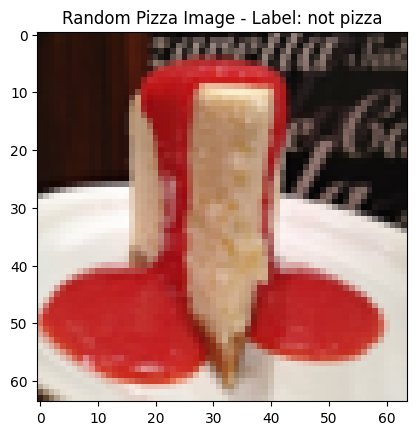

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import random

#getting a random pizza!
random_pizza_from_dataset = random.randint(0, len(train_dataset)-1)
pizza_image, pizza_label = train_dataset[random_pizza_from_dataset]

true_label = "Pizza" if pizza_label == 1 else "not pizza"

print("Random pizza dimensions:", pizza_image.shape)
print("Random pizza label:", true_label)

print(pizza_image)
plt.imshow(pizza_image.permute(1, 2, 0))
plt.title(f"Random Pizza Image - Label: {true_label}")
plt.show()




In [6]:
class TinyVGG(nn.Module):
  def __init__(self, input_channels: int, hidden_units: int, output_classes: int):
    super().__init__()

    self.convolution_block_1 = nn.Sequential(
        nn.Conv2d(input_channels, hidden_units, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2)
    )
    self.convolution_block_2 = nn.Sequential(
        nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2)
    )

    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(hidden_units*16*16, output_classes)
        #because nn shrinks twice
    )

  def forward(self, x):
    x = self.convolution_block_1(x)
    x = self.convolution_block_2(x)
    x = self.classifier(x)
    return x

In [10]:
#intantiating the model

model = TinyVGG(input_channels=3, hidden_units=32, output_classes=2).to(device)

loss_function = nn.CrossEntropyLoss()

optimsing_function = torch.optim.Adam(model.parameters(), lr =1e-7)
print("Model is initiated")


Model is initiated


In [11]:
#training loop:
def trainig_step(model, dataloader, loss_function, optimsing_function, device):
  model.train()
  total_loss, correct = 0, 0
  with torch.inference_mode():
    for X , y in dataloader:
      X, y = X.to(device), y.to(device)

      #computing predictions
      y_pred = model(X)
      loss = loss_function(y_pred, y)
      total_loss += loss.item()

      mr_pizza = y_pred.argmax(dim=1)
      correct += (mr_pizza == y).sum().item()

      accuracy = 100 * correct / len(dataloader.dataset)
      avg_loss= total_loss / len(dataloader)
      return accuracy, avg_loss


def test_step(model, dataloader, loss_function, device):
  model.eval()
  total_loss, correct = 0, 0
  with torch.inference_mode():

    for X , y in dataloader:
      X, y = X.to(device), y.to(device)

      y_pred = model(X)
      loss = loss_function(y_pred, y)
      total_loss += loss.item()

      mr_pizza = y_pred.argmax(dim=1)
      correct += (mr_pizza == y).sum().item()

  accuracy = 100 * correct / len(dataloader.dataset)
  avg_loss= total_loss / len(dataloader)
  return accuracy, avg_loss



In [12]:
#actually predicting

epochs = 50

for epoch in range(epochs):
  train_loss, training_accuracy = trainig_step(model, train_dataloader, loss_function, optimsing_function, device)
  test_loss, test_accuracy = test_step(model, test_dataloader, loss_function, device)

  print(
      f"Epoch {epoch+1}/{epochs}, "
      f"Train Loss: {train_loss:.4f}, "
      f"Train Accuracy: {training_accuracy:.2f}%, "
      f"Test Loss: {test_loss:.4f}, "
      f"Test Accuracy: {test_accuracy:.2f}%"
  )

Epoch 1/50, Train Loss: 1.0814, Train Accuracy: 0.01%, Test Loss: 50.0000, Test Accuracy: 0.69%
Epoch 2/50, Train Loss: 0.8906, Train Accuracy: 0.01%, Test Loss: 50.0000, Test Accuracy: 0.69%
Epoch 3/50, Train Loss: 1.0814, Train Accuracy: 0.01%, Test Loss: 50.0000, Test Accuracy: 0.69%
Epoch 4/50, Train Loss: 0.9542, Train Accuracy: 0.01%, Test Loss: 50.0000, Test Accuracy: 0.69%
Epoch 5/50, Train Loss: 1.2087, Train Accuracy: 0.01%, Test Loss: 50.0000, Test Accuracy: 0.69%
Epoch 6/50, Train Loss: 1.0814, Train Accuracy: 0.01%, Test Loss: 50.0000, Test Accuracy: 0.69%
Epoch 7/50, Train Loss: 1.0814, Train Accuracy: 0.01%, Test Loss: 50.0000, Test Accuracy: 0.69%
Epoch 8/50, Train Loss: 1.0814, Train Accuracy: 0.01%, Test Loss: 50.0000, Test Accuracy: 0.69%
Epoch 9/50, Train Loss: 1.0178, Train Accuracy: 0.01%, Test Loss: 50.0000, Test Accuracy: 0.69%
Epoch 10/50, Train Loss: 1.2087, Train Accuracy: 0.01%, Test Loss: 50.0000, Test Accuracy: 0.69%
Epoch 11/50, Train Loss: 0.8270, Train 

HTTP Status Code: 200
Content-Type: image/jpeg
Image opened successfully.


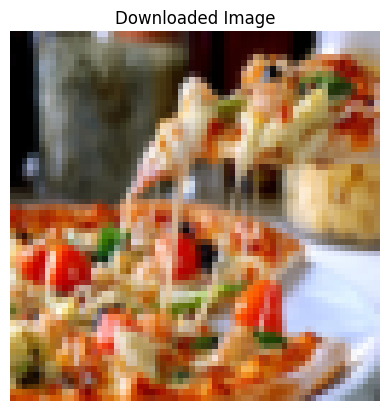

In [ ]:
#using a random image from google to see if the model predicts it right or wrong
import requests
from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt

# New attempt with a robust, direct JPG image URL
url = "https://cdn.pixabay.com/photo/2020/05/17/04/22/pizza-5179939_960_720.jpg"

request = requests.get(url)

print(f"HTTP Status Code: {request.status_code}")
if 'Content-Type' in request.headers:
    print(f"Content-Type: {request.headers['Content-Type']}")
else:
    print("Content-Type header not found.")

try:
    image = Image.open(BytesIO(request.content)).convert("RGB")
    print("Image opened successfully.")
except Exception as e:
    print(f"Still unable to open image: {e}")


image_tensor = data_transformation(image).unsqueeze(0).to(device)

# Display the image tensor using matplotlib
plt.imshow(image_tensor.squeeze(0).permute(1, 2, 0).cpu().numpy())
plt.title("Downloaded Image")
plt.axis('off')
plt.show()

Prediction:  ['pizza']
Probability:  0.5007292628288269


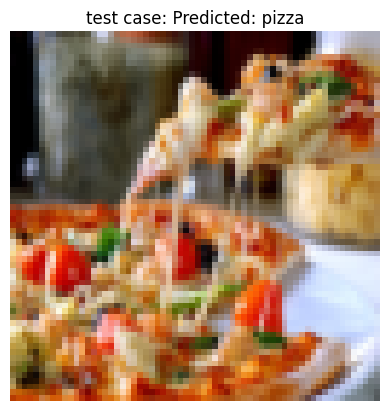

In [ ]:
import torchvision.transforms as transforms
import torch
import matplotlib.pyplot as plt

transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()

])
input_image_for_testing = transform(image).unsqueeze(0).to(device)

model.eval()

with torch.inference_mode():
  output = model(input_image_for_testing)
  probability = torch.softmax(output, dim=1)
  label_mapping = {0: "not_pizza", 1: "pizza"}
  predicted_class = torch.argmax(probability, dim=1).item()
  predicted_label = label_mapping[predicted_class]


print("Prediction: ", [predicted_label])
print("Probability: ", probability[0][predicted_class].item())


plt.imshow(input_image_for_testing.squeeze(0).permute(1, 2, 0).cpu().numpy())
plt.title(f"test case: Predicted: {predicted_label}") # Fixed: concatenate strings into one
plt.axis('off')
plt.show()